This notebook is the training-validation process using **ligthGBM** in [IJCAI-18 Alimama Sponsored Search Conversion Rate(CVR) Prediction Contest](https://tianchi.aliyun.com/competition/introduction.htm?spm=5176.100067.5678.1.76717d56Uh6iE0&raceId=231647) (1st stage). For submission, we train on full training set and set the parameters based on conclusions we draw in this notebook.
#### Feature Engineering

I basically engineered around 25 features, then with original id / score level features. Feature importance is plotted therefore we can clearly see which features are powerful for prediction.

#### Hyperparameters

Hyperparameters for LGBM are not perfectly tuned, I just change some of them and adjust by checking validation error.

#### Validation Strategy

The validation strategy is as follows: 1) rearrange the data, sort samples by `context_timestamp`; 2) choose last 10% of full training set as validation set, the rest 90% are training set.

#### Rank

The result gives me **312/5204** (top 6%)

2018-04-21

In [1]:
import time
import gc
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import log_loss
from contextlib import contextmanager

@contextmanager
def timer(name):
    start_time = time.time()
    yield
    print(f'[{name} done in {time.time() - start_time:.2f} s]')

In [2]:
# ------------------------------------------------------------------------------------
# Following functions basically add groupby aggregation statistics, 
# then merge with original data frame

def add_count(df, cols, cname, value):
    df_count = pd.DataFrame(df.groupby(cols)[value].count()).reset_index()
    df_count.columns = cols + [cname]
    df = df.merge(df_count, on=cols, how='left')
    del df_count
    gc.collect()
    return df

def add_mean(df, cols, cname, value):
    df_mean = pd.DataFrame(df.groupby(cols)[value].mean()).reset_index()
    df_mean.columns = cols + [cname]
    df = df.merge(df_mean, on=cols, how='left')
    del df_mean
    gc.collect()
    return df

def add_std(df, cols, cname, value):
    df_std = pd.DataFrame(df.groupby(cols)[value].std()).reset_index()
    df_std.columns = cols + [cname]
    df = df.merge(df_std, on=cols, how='left')
    del df_std
    gc.collect()
    return df

def add_nunique(df, cols, cname, value):
    df_nunique = pd.DataFrame(df.groupby(cols)[value].nunique()).reset_index()
    df_nunique.columns = cols + [cname]
    df = df.merge(df_nunique, on=cols, how='left')
    del df_nunique
    gc.collect()
    return df
    
def add_cumcount(df, cols, cname):
    df[cname] = df.groupby(cols).cumcount() + 1
    return df

# ------------------------------------------------------------------------------------
# Following functions are dealing with predicted category and property:
# calculate the number of correctly predicted category / property and
# precision / recall

def true_predict_count(true_lst, pred_lst):
    items, cnt = true_lst.split(';'), 0
    for i in pred_lst:
        if i in items:
            cnt += 1
    return cnt

def true_predict_precision(true_lst, pred_lst):
    return true_predict_count(true_lst, pred_lst) / len(pred_lst)

def true_predict_recall(true_lst, pred_lst):
    return true_predict_count(true_lst, pred_lst) / len(true_lst.split(';'))

In [3]:
with timer('Read train and test'):
    train = pd.read_csv('round1_ijcai_18_train_20180301.txt', delimiter=' ')
    test = pd.read_csv('round1_ijcai_18_test_b_20180418.txt', delimiter=' ')
    
    # sort by context_timestamp
    train = train.sort_values(by='context_timestamp').reset_index().iloc[:, 1:]
    
    # split train-validation with 9:1
    ntrain = int(train.shape[0] * .9)
    nval = train.shape[0] - ntrain
    
    val = train.iloc[ntrain:]
    train = train.iloc[:ntrain]
    print(train.shape, val.shape, test.shape)
    print(train.columns)

(430324, 27) (47814, 27) (42888, 26)
Index(['instance_id', 'item_id', 'item_category_list', 'item_property_list',
       'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level',
       'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id',
       'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'predict_category_property',
       'shop_id', 'shop_review_num_level', 'shop_review_positive_rate',
       'shop_star_level', 'shop_score_service', 'shop_score_delivery',
       'shop_score_description', 'is_trade'],
      dtype='object')
[Read train and test done in 7.37 s]


In [4]:
with timer('Feature engineering'):
    
    df_full = [train, val, test]
    df_full_processed = []
    
    # get the customers (users) gender ratio for each shop
    df_shop_gender_ratio = train.groupby(['shop_id'])['user_gender_id']\
                            .agg([lambda x: np.mean(x == 0)])\
                            .reset_index()\
                            .rename(columns={'<lambda>': 'shop_user_gender_ratio'})
    
    # get the average age level of customers for each shop
    df_shop_avg_age_level = train.groupby(['shop_id'])['user_age_level']\
                            .mean()\
                            .reset_index()\
                            .rename(columns={'user_age_level': 'user_avg_age_level'})
                 
    for df in df_full:
        
        # first item_category are same for all samples
        df['item_category_1'] = df['item_category_list'].str.split(';').apply(lambda x: x[1]).astype(int)
        df['context_page_id'] = df['context_page_id'] % 4000
        
        # convert timestamp into 24 hours
        df['context_timestamp'] = (df['context_timestamp'] - df['context_timestamp'] // (3600 * 24) * (3600 * 24)) // 3600
        
        # count features
        df = add_count(df, cols=['user_id'], cname='user_count', value='item_id')
        df = add_count(df, cols=['user_id', 'shop_id'], cname='user_shop_count', value='item_id')
        df = add_count(df, cols=['user_id', 'item_id'], cname='user_item_count', value='item_brand_id')
        df = add_count(df, cols=['user_id', 'shop_id', 'item_id'], cname='user_shop_item_count', value='item_brand_id')
        
        # cumulative count features
        df = add_cumcount(df, cols=['user_id'], cname='user_cumcount')
        df = add_cumcount(df, cols=['user_id', 'shop_id'], cname='user_shop_cumcount')
        df = add_cumcount(df, cols=['user_id', 'item_id'], cname='user_item_cumcount')
        df = add_cumcount(df, cols=['user_id', 'shop_id', 'item_id'], cname='user_shop_item_cumcount')
        
        # unique count features
        df = add_nunique(df, cols=['shop_id'], cname='shop_item_nunique', value='item_id')
        df = add_nunique(df, cols=['user_id'], cname='user_item_nunique', value='item_id')
        df = add_nunique(df, cols=['user_id'], cname='user_shop_nunique', value='shop_id')
        
        # average features
        df = add_mean(df, cols=['shop_id'], cname='shop_price_mean', value='item_price_level')
        df = add_mean(df, cols=['item_id'], cname='item_price_mean', value='item_price_level')
        df = add_mean(df, cols=['user_id'], cname='user_item_price_mean', value='item_price_level')
        df = add_mean(df, cols=['user_id'], cname='user_item_collected_mean', value='item_collected_level')
        
        df = df.merge(df_shop_gender_ratio, on='shop_id', how='left')
        df = df.merge(df_shop_avg_age_level, on='shop_id', how='left')
         
        df['predict_category'] = df['predict_category_property'].str.split(';')\
            .apply(lambda x: [p[0] for p in [p.split(':') for p in x]])
        
        df['predict_category_count'] = df.apply(lambda x: true_predict_count(x['item_category_list'], x['predict_category']), axis=1)
        df['predict_category_recall'] = df.apply(lambda x: true_predict_recall(x['item_category_list'], x['predict_category']), axis=1)
        
        df_full_processed.append(df)

[Feature engineering done in 47.18 s]


In [5]:
with timer('Prepare for LGBM'):
    
    # columns to excluded
    features_exclude = ['instance_id'
                        , 'item_category_list'
                        , 'item_property_list'
                        , 'item_brand_id'
                        , 'context_id'
                        , 'is_trade'
                        , 'predict_category_property'
                        , 'user_gender_id'
                        , 'shop_star_level'
                        , 'user_id'
                        , 'predict_category'
                        , 'predict_property']
    
    # features
    features = [f for f in df_full_processed[0].columns if f not in features_exclude]
    
    lgb_params = {
        'application'        : 'binary'
        , 'learning_rate'    : 0.009
        , 'max_depth'        : 4
        , 'num_leaves'       : 15
        , 'min_child_samples': 20
        , 'subsample'        : 0.8
        , 'colsample_bytree' : 0.3
        , 'metric'           : 'binary_logloss'
        , 'data_random_seed' : 42
        , 'nthread'          : 4
    }
    
    X_train_lgb = lgb.Dataset(df_full_processed[0][features].values, free_raw_data=True)
    X_train_lgb.set_label(df_full_processed[0]['is_trade'].values)
    
    X_val_lgb = lgb.Dataset(df_full_processed[1][features].values, free_raw_data=True)
    X_val_lgb.set_label(df_full_processed[1]['is_trade'].values)
    
    evals_result = {}
    
    watch_list = [X_train_lgb, X_val_lgb]

[Prepare for LGBM done in 0.19 s]


In [6]:
with timer('Train LGBM'):
    clf_lgb = lgb.train(lgb_params
                       , train_set=watch_list[0]
                       , num_boost_round=10000
                       , valid_sets=watch_list
                       , early_stopping_rounds=200
                       , feature_name=features
                       , evals_result=evals_result
                       , verbose_eval=200)

Training until validation scores don't improve for 200 rounds.
[200]	training's binary_logloss: 0.144622	valid_1's binary_logloss: 0.139305
[400]	training's binary_logloss: 0.0940694	valid_1's binary_logloss: 0.0860847
[600]	training's binary_logloss: 0.0889714	valid_1's binary_logloss: 0.0804316
[800]	training's binary_logloss: 0.0876338	valid_1's binary_logloss: 0.0793277
[1000]	training's binary_logloss: 0.0867849	valid_1's binary_logloss: 0.0788394
[1200]	training's binary_logloss: 0.0861718	valid_1's binary_logloss: 0.0785703
[1400]	training's binary_logloss: 0.0856765	valid_1's binary_logloss: 0.0783996
[1600]	training's binary_logloss: 0.085277	valid_1's binary_logloss: 0.0782894
[1800]	training's binary_logloss: 0.0849559	valid_1's binary_logloss: 0.0782163
[2000]	training's binary_logloss: 0.0846543	valid_1's binary_logloss: 0.0781569
[2200]	training's binary_logloss: 0.0843665	valid_1's binary_logloss: 0.078109
[2400]	training's binary_logloss: 0.0840978	valid_1's binary_logl

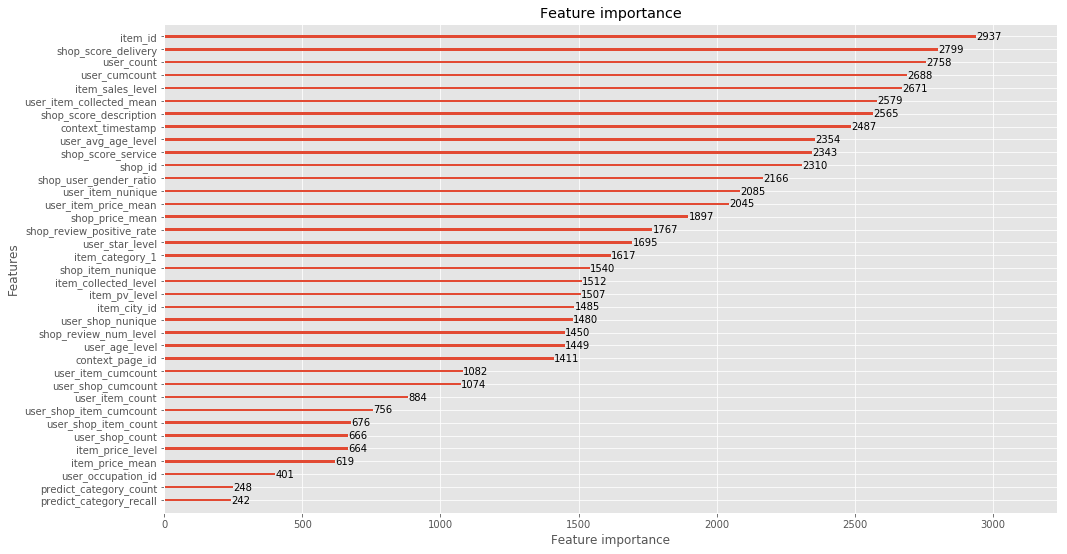

In [7]:
plt.rcParams['figure.figsize'] = 16, 9
lgb.plot_importance(clf_lgb)
plt.show()

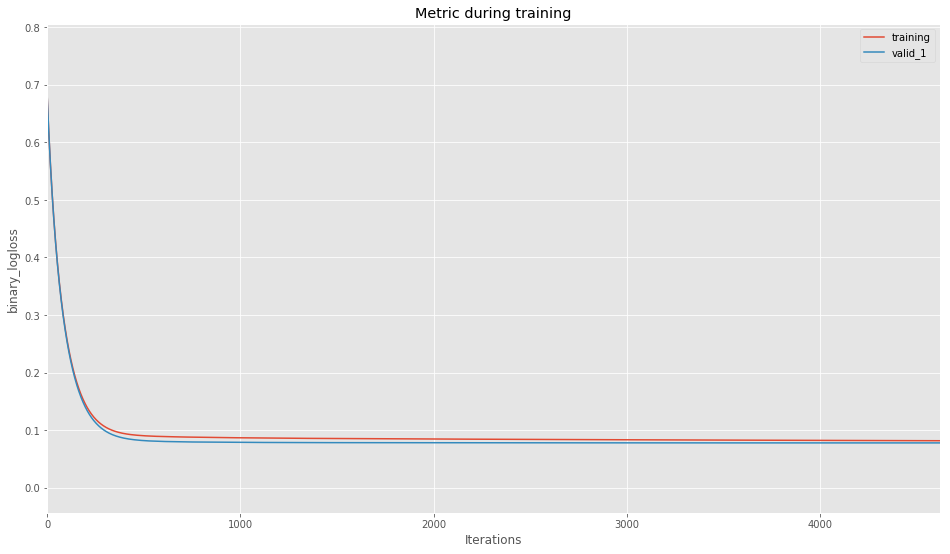

In [8]:
lgb.plot_metric(evals_result)
plt.show()